<a href="https://colab.research.google.com/github/luciainnocenti/German-Credit-Data/blob/master/MML_Tesina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This project is about the analysis of credit risks of German Credit Data.
The dataset is [Statlog (German Credit Data) Data Set](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29).
It is composed by 1000 instances, each one defined by twenty attributes (both numerical and categorical).

The data are collected in 1994 and the last attribute referred to how the client has been categorized: good or bad credit risk.



# Imports



1.   **Files**: needed to upload the file directly from an external source
2.   **Pandas**: needed for manage data as matrices or vectors; provide many usefull function and especially the structure of Dataframe
3.  **Numpy**: needed for manage data as matrices or vectors; 
4.  **Pyplot** and **Seaborn**: useful for visualizations


In [1]:
import warnings
warnings.filterwarnings(action = 'ignore')

# from google.colab import files
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns

#Import classification methods and support methods
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import xgboost as xgb

#Import Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

SEED = 42

In [3]:
df = pd.read_csv('data.csv', sep=';', header=None)
df.head(2)

0   1    2    3     4    5    6   7    8     9   ...    11  12    13  \
0  A11   6  A34  A43  1169  A65  A75   4  A93  A101  ...  A121  67  A143   
1  A12  48  A32  A43  5951  A61  A73   2  A92  A101  ...  A121  22  A143   

     14 15    16 17    18    19 20  
0  A152  2  A173  1  A192  A201  1  
1  A152  1  A173  1  A191  A201  2  

[2 rows x 21 columns]

# Data Exploration

In order to better define how the dataset is done, let's see some characteristics of features and data.
First, I have to rename all the columns because the original dataset haven't the header. So, starting from the description available in the original page, the resulting dataset is:

In [4]:
df.columns = ['checkingAccount','duration','creditHistory', 'purpose', 'creditAmount','savingsAcc','employmentTime', 'installmentPercIncome', 
              'status', 'otherFin', 'timeResidence', 'property' ,'age', 'otherInstallPlans' ,'housing' ,'numCredits', 'job', 'numOfMant', 'phone', 'foreignWorker', 'risk']
df['risk'] = df['risk'] - 1 #(0 = Good, 1 = Bad)
df.head(2)

checkingAccount  duration creditHistory purpose  creditAmount savingsAcc  \
0             A11         6           A34     A43          1169        A65   
1             A12        48           A32     A43          5951        A61   

  employmentTime  installmentPercIncome status otherFin  ...  property age  \
0            A75                      4    A93     A101  ...      A121  67   
1            A73                      2    A92     A101  ...      A121  22   

   otherInstallPlans housing numCredits   job numOfMant  phone foreignWorker  \
0               A143    A152          2  A173         1   A192          A201   
1               A143    A152          1  A173         1   A191          A201   

  risk  
0    0  
1    1  

[2 rows x 21 columns]

The description says that the dataset does not allow for null values. Let's check it:

In [5]:
df.isnull().values.any()

False

In [6]:
df['risk'] = df['risk'].astype('category')

## Numerical Data

The dataset is composed both from numerical and categorical attributes.

It is possbile to analize numerical ones by using the method describe, which print the following stats:


*   **Count** the total number of instances
*   **Mean** of all the instances
*   **Std** of all the instances
*   **Min** return the minimum value 
*   **25%, 50%, 75%** are percentile values for each attribute
*   **Max** return the maximum value



In [7]:
df.describe()

duration  creditAmount  installmentPercIncome  timeResidence  \
count  1000.000000   1000.000000            1000.000000    1000.000000   
mean     20.903000   3271.258000               2.973000       2.845000   
std      12.058814   2822.736876               1.118715       1.103718   
min       4.000000    250.000000               1.000000       1.000000   
25%      12.000000   1365.500000               2.000000       2.000000   
50%      18.000000   2319.500000               3.000000       3.000000   
75%      24.000000   3972.250000               4.000000       4.000000   
max      72.000000  18424.000000               4.000000       4.000000   

               age   numCredits    numOfMant  
count  1000.000000  1000.000000  1000.000000  
mean     35.546000     1.407000     1.155000  
std      11.375469     0.577654     0.362086  
min      19.000000     1.000000     1.000000  
25%      27.000000     1.000000     1.000000  
50%      33.000000     1.000000     1.000000  
75%      42.000000     2.000000     1.000000  
max      75.000000     4.000000     2.000000

Let's make some observations about other features:
*   *Duration* hasn't strange values, data are well distributed into the interval of values.
*   *CreditAmount* has a large standard deviation, a possible approach in order to identify possible wrong data is to visualize it by grouping for Purpose.
*   *Age* has as minimum value 19 years and as maximum value 75 year, so it perfectly fit expectations.




Text(0.5, 1.0, 'Correlation Heatmap')

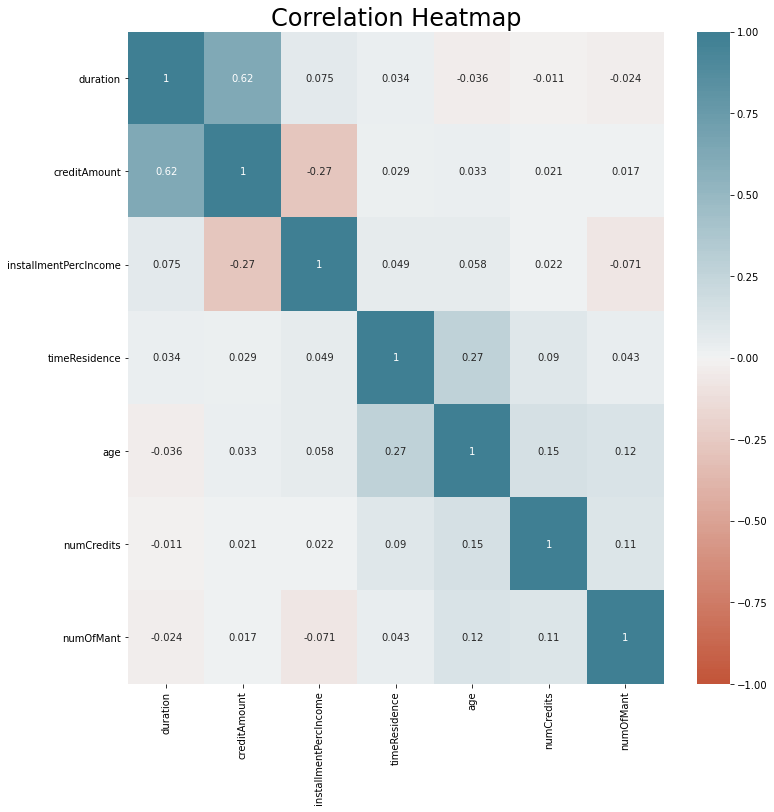

In [8]:
numerical = df.select_dtypes(include=['int64'])
numerical = (numerical-numerical.mean())/numerical.std()
corr = numerical.corr()
plt.figure(figsize = (12,12))
sns.heatmap(corr, annot = True, 
            vmin = -1, vmax = 1, center = 0,
            cmap = sns.diverging_palette(20, 220, n = 200))
plt.title('Correlation Heatmap', fontsize = 24)

The correlation map shows that, as expected, the highest correlation is the one between duration and creditAmount; there are not other important correlations

## Categorical Data

To analize categorical data it is possible to use the plot of frequencies:

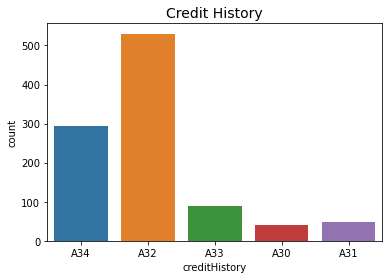

In [9]:
sns.countplot('creditHistory', data=df)
plt.title('Credit History', fontsize=14)
plt.show()

Credit history

*    A30 : no credits taken/ all credits paid back duly
*    A31 : all credits at this bank paid back duly
*    A32 : existing credits paid back duly till now
*    A33 : delay in paying off in the past
*    A34 : critical account/ other credits existing (not at this bank)

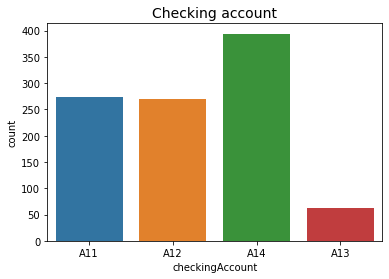

In [10]:
sns.countplot('checkingAccount', data=df)
plt.title('Checking account', fontsize=14)
plt.show()

Status of existing checking account
* A11 : ... < 0 DM
* A12 : 0 <= ... < 200 DM
* A13 : ... >= 200 DM / salary assignments for at least 1 year
* A14 : no checking account

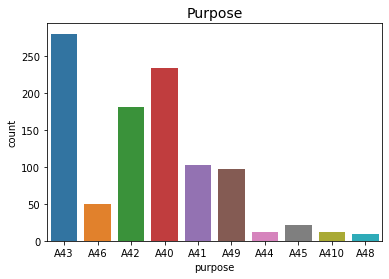

In [11]:
sns.countplot('purpose', data=df)
plt.title('Purpose', fontsize=14)
plt.show()

Purpose
* A40 : car (new)
* A41 : car (used)
* A42 : furniture/equipment
* A43 : radio/television
* A44 : domestic appliances
* A45 : repairs
* A46 : education
* A47 : (vacation - does not exist?)
* A48 : retraining
* A49 : business
* A410 : others

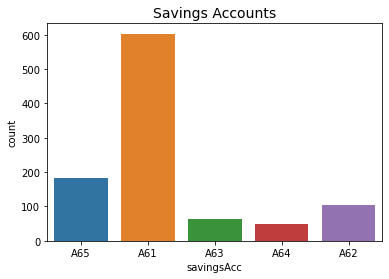

In [12]:
sns.countplot('savingsAcc', data=df)
plt.title('Savings Accounts', fontsize=14)
plt.show()

Savings account/bonds
* A61 : ... < 100 DM
* A62 : 100 <= ... < 500 DM
* A63 : 500 <= ... < 1000 DM
* A64 : .. >= 1000 DM
* A65 : unknown/ no savings account


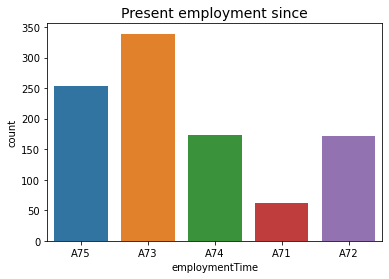

In [13]:
sns.countplot('employmentTime', data=df)
plt.title('Present employment since', fontsize=14)
plt.show()

Present employment since
* A71 : unemployed
* A72 : ... < 1 year
* A73 : 1 <= ... < 4 years
* A74 : 4 <= ... < 7 years
* A75 : .. >= 7 years

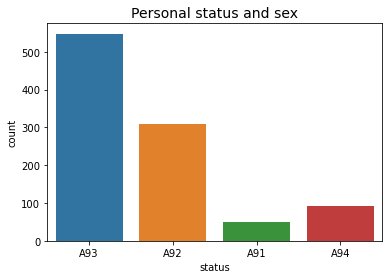

In [14]:
sns.countplot('status', data=df)
plt.title('Personal status and sex', fontsize=14)
plt.show()

Personal status and sex
* A91 : male : divorced/separated
* A92 : female : divorced/separated/married
* A93 : male : single
* A94 : male : married/widowed
* A95 : female : single

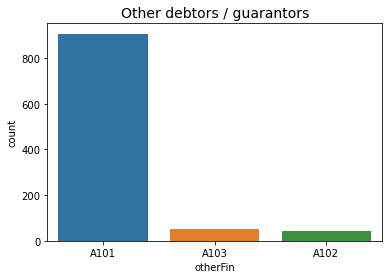

In [15]:
sns.countplot('otherFin', data=df)
plt.title('Other debtors / guarantors', fontsize=14)
plt.show()

Other debtors / guarantors
* A101 : none
* A102 : co-applicant
* A103 : guarantor 


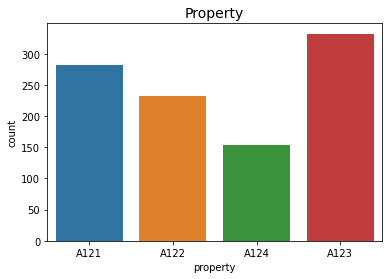

In [16]:
sns.countplot('property', data=df)
plt.title('Property', fontsize=14)
plt.show()

Property
* A121 : real estate
* A122 : if not A121 : building society savings agreement/ life insurance
* A123 : if not A121/A122 : car or other, not in attribute 6
* A124 : unknown / no property


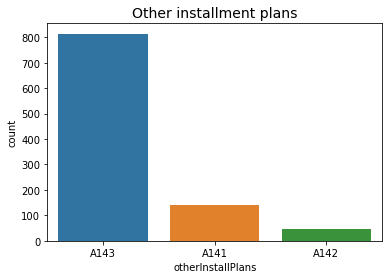

In [17]:
sns.countplot('otherInstallPlans', data=df)
plt.title('Other installment plans', fontsize=14)
plt.show()

Other installment plans
* A141 : bank
* A142 : stores
* A143 : none

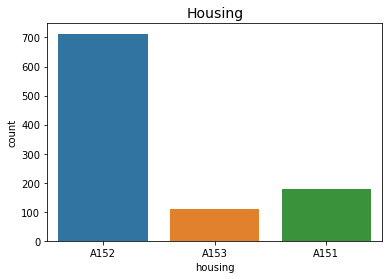

In [18]:
sns.countplot('housing', data=df)
plt.title('Housing', fontsize=14)
plt.show()

Housing
* A151 : rent
* A152 : own
* A153 : for free

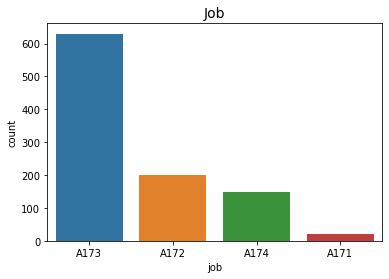

In [19]:
sns.countplot('job', data=df)
plt.title('Job', fontsize=14)
plt.show()

Job
* A171 : unemployed/ unskilled - non-resident
* A172 : unskilled - resident
* A173 : skilled employee / official
* A174 : management/ self-employed/highly qualified employee/ officer

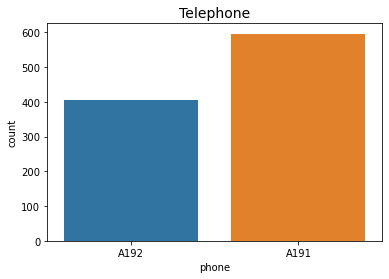

In [20]:
sns.countplot('phone', data=df)
plt.title('Telephone', fontsize=14)
plt.show()

Telephone
* A191 : none
* A192 : yes, registered under the customers name

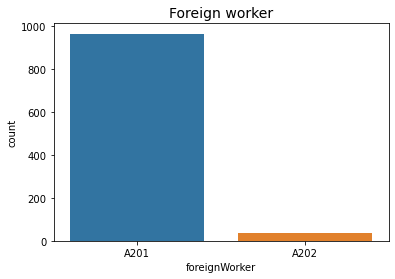

In [21]:
sns.countplot('foreignWorker', data=df)
plt.title('Foreign worker', fontsize=14)
plt.show()

Foreign worker
* A201 : yes
* A202 : no

From these plots, nothing of relevant has been detected.
Let's take a look to the frequency plot for the risk value:

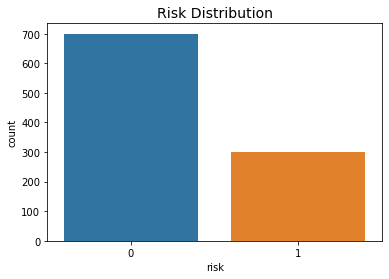

In [22]:
sns.countplot('risk', data=df)
plt.title('Risk Distribution', fontsize=14)
plt.show()

As said before, the 2 categories are not perfectly balanced.
Different approaches can be selected now. Let's take a look to outliers and other aspects of raw data, and then we will face this aspect.

## Distribution and Outliers

The numerical attributes in German Credit Risk data have many outliers. Some plot can help to understand:

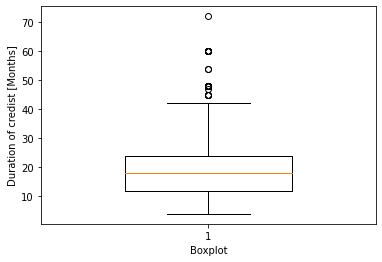

In [23]:
plt.boxplot(df['duration'], widths = 0.5)
plt.ylabel('Duration of credist [Months]')
plt.xlabel('Boxplot')
plt.show()

The average value for the duration of credits is 20 months, but some values are higher that 50. We can go deep and see if these values are trusted:

In [24]:
df[ df['duration'] > 50]

checkingAccount  duration creditHistory purpose  creditAmount savingsAcc  \
29              A11        60           A33     A49          6836        A61   
78              A14        54           A30     A41          9436        A65   
95              A12        54           A30     A49         15945        A61   
134             A14        60           A32     A43         10144        A62   
255             A12        60           A33     A43          7418        A65   
332             A12        60           A32     A40          7408        A62   
373             A14        60           A34     A40         13756        A65   
374             A12        60           A31    A410         14782        A62   
616             A12        60           A33     A43          9157        A65   
637             A14        60           A33     A43         15653        A61   
672             A14        60           A32     A40         10366        A61   
677             A12        72           A32     A43          5595        A62   
685             A14        60           A32     A40          6527        A65   
714             A12        60           A32     A40         14027        A61   
938             A12        60           A32     A46          6288        A61   
973             A11        60           A32     A49          7297        A61   

    employmentTime  installmentPercIncome status otherFin  ...  property age  \
29             A75                      3    A93     A101  ...      A124  63   
78             A73                      2    A93     A101  ...      A122  39   
95             A72                      3    A93     A101  ...      A124  58   
134            A74                      2    A92     A101  ...      A121  21   
255            A73                      1    A93     A101  ...      A121  27   
332            A72                      4    A92     A101  ...      A122  24   
373            A75                      2    A93     A101  ...      A124  63   
374            A75                      3    A92     A101  ...      A124  60   
616            A73                      2    A93     A101  ...      A124  27   
637            A74                      2    A93     A101  ...      A123  21   
672            A75                      2    A93     A101  ...      A122  42   
677            A73                      2    A94     A101  ...      A123  24   
685            A73                      4    A93     A101  ...      A124  34   
714            A74                      4    A93     A101  ...      A124  27   
938            A73                      4    A93     A101  ...      A124  42   
973            A75                      4    A93     A102  ...      A124  36   

     otherInstallPlans housing numCredits   job numOfMant  phone  \
29                A143    A152          2  A173         1   A192   
78                A143    A152          1  A172         2   A191   
95                A143    A151          1  A173         1   A192   
134               A143    A152          1  A173         1   A192   
255               A143    A152          1  A172         1   A191   
332               A143    A152          1  A174         1   A191   
373               A141    A153          1  A174         1   A192   
374               A141    A153          2  A174         1   A192   
616               A143    A153          1  A174         1   A191   
637               A143    A152          2  A173         1   A192   
672               A143    A152          1  A174         1   A192   
677               A143    A152          1  A173         1   A191   
685               A143    A153          1  A173         2   A192   
714               A143    A152          1  A174         1   A192   
938               A143    A153          1  A173         1   A191   
973               A143    A151          1  A173         1   A191   

    foreignWorker risk  
29           A201    1  
78           A201    0  
95           A201    1  
134          A201    0  


We can see that there is not a recurrent pattern in this data, so we have no reasons to don't trust it.

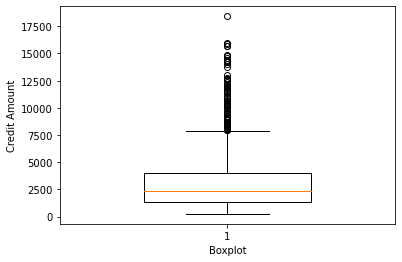

In [25]:
plt.boxplot(df['creditAmount'], widths = 0.5)
plt.ylabel('Credit Amount')
plt.xlabel('Boxplot')
plt.show()

In [26]:
df[ df['creditAmount'] > 7500].set_index(['risk','creditAmount', 'duration']).count(level="risk")

checkingAccount  creditHistory  purpose  savingsAcc  employmentTime  \
risk                                                                        
0                  42             42       42          42              42   
1                  44             44       44          44              44   

      installmentPercIncome  status  otherFin  timeResidence  property  age  \
risk                                                                          
0                        42      42        42             42        42   42   
1                        44      44        44             44        44   44   

      otherInstallPlans  housing  numCredits  job  numOfMant  phone  \
risk                                                                  
0                    42       42          42   42         42     42   
1                    44       44          44   44         44     44   

      foreignWorker  
risk                 
0                42  
1                44

## Correlations

Starting from the informations taked out from the heat map, we want to go deep into the analisys of them, in order to decide if some values can be dropped out from the dataset:

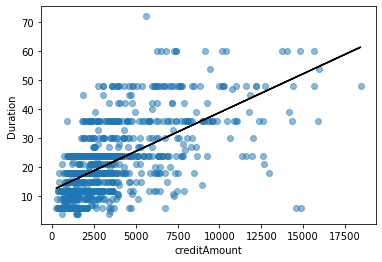

In [27]:
x = df['creditAmount']
y = df['duration']
plt.scatter(x, y, alpha=0.5)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"black")
plt.xlabel('creditAmount')
plt.ylabel('Duration')
plt.show()

As expected, the number of rates and the amount of credit are positivly correlated. But we can see different elements that have a high variance, so we cannot drop out one of the attributes as if has been completly represented by the other one

# Data Preparation

## One hot Encoding

Apart from the target variabile, the dataset we use has now 7 numerical features and 13 categorical feature. Two of them are binary values, the others are nominal ones.

There is something to do in order to work with the nominal values. 
One approach can be to map it into numerical value; so each level of a categorical feature corresponds to an integer value.
The problem is that numerical values implies an order, but for our data this is not the correct approach.
To overcame this problem, the most commonly technique used is one hot encoding. Each category value is converted into a new column: we assign 1 to the corresponding value and 0 to everything else.
Let's look what happens in this case:

In [28]:
categorical = ['checkingAccount', 'creditHistory', 'purpose', 'savingsAcc', 'employmentTime', 'status', 'otherFin', 'property', 'otherInstallPlans', 'housing', 'job']

In [29]:
Y = df['risk'].copy()
oneHotDF = df.copy()
oneHotDF.drop(['risk'],axis=1, inplace=True)

for att in categorical:
  oneHotDF = pd.concat([oneHotDF,pd.get_dummies(oneHotDF[att], prefix = att)], axis=1)
  oneHotDF .drop([att],axis=1, inplace=True)
oneHotDF

duration  creditAmount  installmentPercIncome  timeResidence  age  \
0           6          1169                      4              4   67   
1          48          5951                      2              2   22   
2          12          2096                      2              3   49   
3          42          7882                      2              4   45   
4          24          4870                      3              4   53   
..        ...           ...                    ...            ...  ...   
995        12          1736                      3              4   31   
996        30          3857                      4              4   40   
997        12           804                      4              4   38   
998        45          1845                      4              4   23   
999        45          4576                      3              4   27   

     numCredits  numOfMant phone foreignWorker  checkingAccount_A11  ...  \
0             2          1  A192          A201                    1  ...   
1             1          1  A191          A201                    0  ...   
2             1          2  A191          A201                    0  ...   
3             1          2  A191          A201                    1  ...   
4             2          2  A191          A201                    1  ...   
..          ...        ...   ...           ...                  ...  ...   
995           1          1  A191          A201                    0  ...   
996           1          1  A192          A201                    1  ...   
997           1          1  A191          A201                    0  ...   
998           1          1  A192          A201                    1  ...   
999           1          1  A191          A201                    0  ...   

     otherInstallPlans_A141  otherInstallPlans_A142  otherInstallPlans_A143  \
0                         0                       0                       1   
1                         0                       0                       1   
2                         0                       0                       1   
3                         0                       0                       1   
4                         0                       0                       1   
..                      ...                     ...                     ...   
995                       0                       0                       1   
996                       0                       0                       1   
997                       0                       0                       1   
998                       0                       0                       1   
999                       0                       0                       1   

     housing_A151  housing_A152  housing_A153  job_A171  job_A172  job_A173  \
0               0             1             0         0         0         1   
1               0             1             0         0         0         1   
2               0             1             0         0         1         0   
3               0             0             1         0         0         1   
4               0             0             1         0         0         1   
..            ...           ...           ...       ...       ...       ...   
995             0             1             0         0         1         0   
996             0             1             0         0         0         0   
997             0             1             0         0         0         1   
998             0             0             1         0         0         1   
999             0             1             0         0         0         1   

     job_A174  
0           0  
1           0  
2           0  
3           0  
4           0  
..        ...  
995         0  
996         1  
997         0  
998         0  
999         0  

[1000 rows x 59 columns]

Binary categorical features can be mapped as 0-1 variables:

In [30]:
phoneMapping = {
    'A191' : 1,
    'A192' : 0
}

foreignWorkerMapping = {
    'A202' : 1,
    'A201' : 0
}
oneHotDF['phone'] = oneHotDF['phone'].map(phoneMapping)
oneHotDF['foreignWorker'] = oneHotDF['foreignWorker'].map(foreignWorkerMapping)

In [31]:
oneHotDF

duration  creditAmount  installmentPercIncome  timeResidence  age  \
0           6          1169                      4              4   67   
1          48          5951                      2              2   22   
2          12          2096                      2              3   49   
3          42          7882                      2              4   45   
4          24          4870                      3              4   53   
..        ...           ...                    ...            ...  ...   
995        12          1736                      3              4   31   
996        30          3857                      4              4   40   
997        12           804                      4              4   38   
998        45          1845                      4              4   23   
999        45          4576                      3              4   27   

     numCredits  numOfMant  phone  foreignWorker  checkingAccount_A11  ...  \
0             2          1      0              0                    1  ...   
1             1          1      1              0                    0  ...   
2             1          2      1              0                    0  ...   
3             1          2      1              0                    1  ...   
4             2          2      1              0                    1  ...   
..          ...        ...    ...            ...                  ...  ...   
995           1          1      1              0                    0  ...   
996           1          1      0              0                    1  ...   
997           1          1      1              0                    0  ...   
998           1          1      0              0                    1  ...   
999           1          1      1              0                    0  ...   

     otherInstallPlans_A141  otherInstallPlans_A142  otherInstallPlans_A143  \
0                         0                       0                       1   
1                         0                       0                       1   
2                         0                       0                       1   
3                         0                       0                       1   
4                         0                       0                       1   
..                      ...                     ...                     ...   
995                       0                       0                       1   
996                       0                       0                       1   
997                       0                       0                       1   
998                       0                       0                       1   
999                       0                       0                       1   

     housing_A151  housing_A152  housing_A153  job_A171  job_A172  job_A173  \
0               0             1             0         0         0         1   
1               0             1             0         0         0         1   
2               0             1             0         0         1         0   
3               0             0             1         0         0         1   
4               0             0             1         0         0         1   
..            ...           ...           ...       ...       ...       ...   
995             0             1             0         0         1         0   
996             0             1             0         0         0         0   
997             0             1             0         0         0         1   
998             0             0             1         0         0         1   
999             0             1             0         0         0         1   

     job_A174  
0           0  
1           0  
2           0  
3           0  
4           0  
..        ...  
995         0  
996         1  
997         0  
998         0  
999         0  

[1000 rows x 59 columns]

The one-hot-encoding procedure is necessary, but we can see that it has create a dataframe having three times the number of columns than the initial one. 


## PCA

The PCA (Principal Components Analysis) is a tecnique of dimensionality reduction, based on the idea of preserve the highest variance among the data but reducing the number of features.

Principal component are a new coordinate system. Given data on D variables, the hope is that the data points will lie mainly in a linear subspace of dimension d < D.
The PCs decompose the total variance of the data, so the sum of the variance among all the PCs corresponds to the total variance among original data.

The first PCs is the one which have the higher variance, the last PCs is the one having lower variance.

Each PC is an ortogonal linear transformation of the original data.


In [32]:
X_pca = oneHotDF.copy()
# Normalize:
X_pca_norm = (X_pca-X_pca.mean())/X_pca.std()
print("There are " + ("some" if X_pca_norm.isnull().values.any() else "no")  + " null/missing values in the dataset.")

There are no null/missing values in the dataset.


Text(0, 0.5, 'Variance explained')

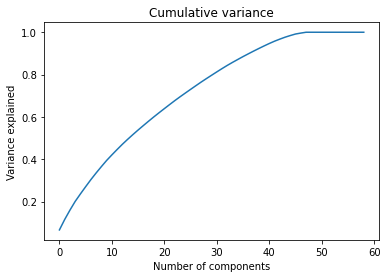

In [33]:
# calculate the principal components
X_pca = PCA(random_state = SEED).fit(X_pca_norm)
cumvar = np.cumsum(X_pca.explained_variance_ratio_)
#Plotting cumulative variance
plt.plot(cumvar)
plt.title('Cumulative variance')
plt.xlabel('Number of components')
plt.ylabel('Variance explained')

In [34]:
cumvar[35]

0.8850792991002367

In [35]:
n_used = 35
X_pca = np.dot(X_pca_norm.values, X_pca.components_[:n_used,:].T)
X_pca = pd.DataFrame(X_pca, columns=["PC%d" % (x + 1) for x in range(n_used)])
X_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  1.082157 -3.197403  1.416799 -2.128576  0.794921 -0.032605 -0.021152   
1 -2.046062  1.181714 -1.460144  1.090682  0.986275  0.073940  0.824098   
2  0.043917 -2.317239  2.305621 -0.914054 -1.172443 -0.329090  0.427019   
3  1.187569  2.782986  2.257115 -0.116350  4.270613  1.934985 -0.088762   
4  3.320006  0.783071  1.719462 -1.520643  0.621341  1.081563 -0.930741   

        PC8       PC9      PC10  ...      PC26      PC27      PC28      PC29  \
0 -0.104399  1.391877 -0.485826  ... -0.850239  0.514253 -0.721604 -0.165025   
1  0.083795 -0.873888 -1.949324  ... -1.844986 -0.568349 -0.061486 -0.095967   
2 -0.464922 -1.435776  0.389333  ...  0.688406  1.459506 -0.497424  0.725172   
3 -0.443202 -1.152752  2.655444  ... -0.143454 -1.016785  0.442327  0.612784   
4 -1.235018 -3.484279 -0.972879  ... -1.299154  0.108081  1.376801 -0.246205   

       PC30      PC31      PC32      PC33      PC34      PC35  
0 -0.149025 -0.320648 -0.054975  1.363490 -0.330293 -0.844084  
1  0.726449 -0.173887  0.472890  0.432070 -0.230725 -0.391088  
2 -0.507362 -1.045211  2.010000  1.738597 -0.101321 -0.234409  
3 -0.155964  0.221144 -0.315698  0.236581 -0.378430  0.183735  
4  1.513928  0.396242 -1.092485 -0.486634 -0.607261  0.491395  

[5 rows x 35 columns]

In [36]:
Y.head()

0    0
1    1
2    0
3    0
4    1
Name: risk, dtype: category
Categories (2, int64): [0, 1]

### Train and Test set for PCA model

In order to create a learning algorith able to classify instances, we need to create a training set $S$, sampled from the entire dataset $D$, and to train our model triyng to minimize the training error.
This approach is based on the *Empirical Risk Minimization paradigm*, a learning paradigm that starts from the idea that, if S is representative of $D$, minimizing the error on $S$ we are also minimizing the error on $D$.
Let's define the error on $S$, given an hypotesis $h$, as:\
$$ L_s(h) =\frac{ \{ |i  \in [m] : h(x_i) \ne y_i   \}  }{m} $$
where:
*  $m$ is the training size
*  $h(x_i)$ is the predicted label
*  $y_i$ is the true label

At each step $i$, the loss is calculated and the hypotesis $h$ is changed in order to minimize $L_s(h)$.

In order to create a training set $S$ that represent the entire set $D$, let's define a set that preserve the proportionality among classes (defined by the parameter *stratify*). 

Then, the algorithm trained so far will be tested on the other part of the dataset $D$, the test set.

To approach our problem in this way, however, we need to manually select each algorithm that we want to analyze.
In order to choose the best algorithm (refering to the algorithm itself or the tuned hyperparameters of the algorithm), we need to do a *model selection*: by looking at all the hypothesis $h$, we want the one that best performs on our data.

A very accurate estimation of the true risk can be obtained using both train and validation set: the first for constructing the model and the second to select the best model among all the proposed.

Validation can be naturally used for model selection as follows:
* train the algorith on the training set and construct $H = {h_1,...,h_d}$
* choose a single predictor $h_s$ from $H$: the one that minimizes the error over the validation set
* use $h_s$ on the test set

In other words, we are applying a *ERM* approach to the validation set instead of to the training set.

In [37]:
X, X_test, y, y_test = train_test_split(X_pca, Y, test_size=0.3, stratify = Y)
X_val, X_train, y_val, y_train = train_test_split(X, y, test_size=0.57, stratify = y)

### Data Augmentation

Resampling involves creating a new transformed version of the training dataset in which the selected examples have a different class distribution.

This is a simple and effective strategy for imbalanced classification problems.

The dataset that we are analyzing are not really imbalanced; as we can see in the next box, the proportion between two categories is 7:3:

In [38]:
df['risk'].value_counts()

0    700
1    300
Name: risk, dtype: int64

But it could be intresting to ses a comparization of the performances of different classifiers between the original dataset and an oversampled-one, more balanced that the current one.

In [39]:
X_ADASYN, y_ADASYN = ADASYN().fit_resample(X_train, y_train)
print("Oversampling on X generate a dataset of ", X_ADASYN.shape, "istances, while the original dataset had ", X_train.shape, " instances")
print( 'The new dataset has' , np.count_nonzero(y_ADASYN == 0), 'elements for riks = good, and', np.count_nonzero(y_ADASYN == 1), 'elements for riks = bad')

Oversampling on X generate a dataset of  (560, 35) istances, while the original dataset had  (399, 35)  instances
The new dataset has 279 elements for riks = good, and 281 elements for riks = bad


In [40]:
X_SMOTE, y_SMOTE = SMOTE().fit_resample(X_train, y_train)
print("Oversampling on X generate a dataset of ", X_SMOTE.shape, "istances, while the original dataset had ", X_train.shape, " instances")
print( 'The new dataset has' , np.count_nonzero(y_SMOTE == 0), 'elements for riks = good, and', np.count_nonzero(y_SMOTE == 1), 'elements for riks = bad')

Oversampling on X generate a dataset of  (558, 35) istances, while the original dataset had  (399, 35)  instances
The new dataset has 279 elements for riks = good, and 279 elements for riks = bad


So we can apply different classification algorithms both to **X**, **X_ADASYN** and **X_SMOTE** and find the one that has the best performance.

## Features Selection

Feature selection is the process of reducing the number of input variables when developing a predictive model.
It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model.

By looking at our dataset, we can see that we have both qualitative and quantitative predictors

So we can use an ***Anova F-Test*** test in order to select the best features.


In [41]:
kbest = SelectKBest(f_classif)

### K-fold Cross Validation

In the PCA approach, select the number of selected PC for the model is easy: by looking at the cumulative variances we have an immediate way to evaluate how good the model is.

But, in features selection, there is a different approach:
we need to set a priori the hyperparameter K and we can evaluate how good the model performs only when the classification models gives its results.

And also the hyperparametes of the classification models need to be tuned. So, at each step, we need to define both K and model hyperparameters.


A good approach, in this case, can be to use a K_Fold Cross-Validation model:
the original dataset is divided in $k$ partitions having $\frac{n}{k}$ elements, where $n$ is the size of the original dataset.
At each step, the $i^{th}$ partition is used as training set and the others $k - 1$ are concatenated and used as validation set.
The model is trained on the training set, and validate on the validation set and the final score for the model is the average mean squared error:\
$CV_{(k)} = \frac{1}{k} \cdot \sum_{i = 1}^{k} {MSE_i}$, where $MSE_i = | Y_i - \hat{Y_i} |^2$ \
being $\hat{Y_i}$ the predictor of $Y_i$ using all the other observations.

The k-fold procedure is done many times and, at each iteration, the model uses a different set of parameters from the grid and, finally, the model providing the best score is selected as the best one and the entire dataset is re-trained by using those hyperparameters.\
In the categorical case, as the one analized here, the error is computed as:\
$CV_{(n)} = \frac{1}{n} \sum_{i = 1}^{n} {Err_i}$, where $ Err_i = I(y_i \neq \hat{y_i})$

In [42]:
Xfs = oneHotDF.copy()
Xfs_train, Xfs_test, yfs_train, yfs_test = train_test_split(Xfs, Y, test_size=0.3, stratify = Y)

### Data Augmentation

The same approach used for the PCA section is used here:

In [43]:
Xfs_ADASYN, yfs_ADASYN = ADASYN().fit_resample(Xfs_train, yfs_train)
print("Oversampling on X generate a dataset of ", Xfs_ADASYN.shape, "istances, while the original dataset had ", Xfs_train.shape, " instances")
print( 'The new dataset has' , np.count_nonzero(yfs_ADASYN == 0), 'elements for riks = good, and', np.count_nonzero(yfs_ADASYN == 1), 'elements for riks = bad')

Oversampling on X generate a dataset of  (1000, 59) istances, while the original dataset had  (700, 59)  instances
The new dataset has 490 elements for riks = good, and 510 elements for riks = bad


In [44]:
Xfs_SMOTE, yfs_SMOTE = SMOTE().fit_resample(Xfs_train, yfs_train)
print("Oversampling on X generate a dataset of ", Xfs_SMOTE.shape, "istances, while the original dataset had ", Xfs_train.shape, " instances")
print( 'The new dataset has' , np.count_nonzero(yfs_SMOTE == 0), 'elements for riks = good, and', np.count_nonzero(yfs_SMOTE == 1), 'elements for riks = bad')

Oversampling on X generate a dataset of  (980, 59) istances, while the original dataset had  (700, 59)  instances
The new dataset has 490 elements for riks = good, and 490 elements for riks = bad


# Classification Algorithms

After having defined all the different datasets, let's start with the classification task: this is the problem of assigning a category to each item.

In order to compare models and find the one that performs better, it's needed to define which metrics will be used to evaluate performances.

Let: $TP$ = True positives, $TN$ = True negative, $FP$ = False positive, $FN$ = False negative.

Accuracy = $\frac{TP + TN}{TP+TN + FP + FN} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}$

Precision = $\frac{\text{TP}}{\text{TP + FP}}$

Sensitivity = $\frac{\text{TP}}{\text{TP + FN}}$


F1 Score = $2 \cdot \frac{\text{Precision}\cdot \text{Sensitivity}}{\text{Precision + Sensitivity}} $




In [45]:
binary_metricsPCA = pd.DataFrame(columns=["Accuracy", "Precision", "Sensitivity", "F1 Score"])
binary_metricsFS = pd.DataFrame(columns=["Accuracy", "Precision", "Sensitivity", "F1 Score"])
binary_metricsORIG = pd.DataFrame(columns=["Accuracy", "Precision", "Sensitivity", "F1 Score"])

## Theory overview

### SVM Method

The basic Support-Vector Machine (SVM) model is linear: it finds the optimal hyperplane between the points of two classes such that the distance of the nearest points to the decision boundary is maximized.

Clearly, it is not common to have a linear separation and SVM can be generalized.

This generalization can be made by choosing a non-linear Kernel function to apply to the support vector machine.

Linear support vector machine generally uses as linear kernel:$$ k({\vec{x_i}},{\vec{x_{j}}})={\vec{x_{i}}}\cdot{\vec{x_{j}}}$$

Probably the common non-lineare alternative is the Radial basis kernel:$${k({\vec{x_i},\vec{x_{j}}})=\exp(-\gamma \|{\vec {x_{i}}}-{\vec {x_{j}}}\|^{2})}$$where $\gamma \gt0$ is a parameter to chose. This is in fact the default kernel function in the library.

Basically, the kernel maps the data into another space in which the class can be linearly separated, while in the original space, the boundary will in general be non linear.

### KNN Method

K-Nearest-Neighbors is one of the simplest classification algorithm in supervised learning. The core idea for KNN is that the features that are used to describe the domain points determinates their classification label. So, features from the same classes need to have similar features. But if we project the domain points in the hyper-space of the features, elements with similar features (and so belonging to the same class) are closer one to each other.
So, the KNN algorithm assigned to a point the label of the closest point(s).
This algorithm has onehyper-parameter:  the value of $k$, that define the number of neighbors to consider in order to have the classification: $k \in \mathbb{N}$.

$k$ must be an odd number in order to avoid uncertain classification in case of binary classification.

The concept of "close" is related to the concept of distance. KNN algorithm use an Euclidean Distances defined as:

$\rho(x, x') = || x - x' || = \sqrt{ \sum_{i=1}^{d}{(x_i - x_i')^2}}$

### Logistic Regression Method

The logistic regression in a generalization of linear regression that allow to solve binary classification problems. In order to execute this generalization, the steps are:
* substitute the normal distribution for error with a Bernoulli Distribution:
$p(y|\hat{x},\hat{w}) = Ber(y| \mu(\hat{x}) ) $, where $\mu(x)$ = $p(y=1| \hat{x})$
* coumpute a linear combination of inputs in order to be shure that $0 \leq \mu({\hat{x}}) \leq 1$ by using a **sigmoid**, that has the following shape:

![Sigmoid function](https://upload.wikimedia.org/wikipedia/commons/5/53/Sigmoid-function-2.svg)



### Decision Trees

A decision tree is a predictor $h : H \to Y$, that predicts the label associated to an instance of $x$ by travelling from the root to the leaf of a tree in which nodes represent features and edges are values.

Usually the decision tree learning algorithm are based on a greedy approach: the tree is constructed gradually and at each step the decision is taken by analize the local optimal decision. So it's not guarantee a global optimal tree.

The model starts with a single leaf, the root. The leaf recives as lable the one according to the majority vote among all labels over the training set. Then, in a set of iterations, the algorithm examinates the possibility of split each leaf and evaluate the gain in splitting it.
Among all the possibile splits, the one that gave the best gain is choosen

### XGBoost

The idea of boosting approach in machine learning is to create highly accurate predictions by combining many low-accurate rules.

Boosting assumes the availability of a base or weak classifier (often small decision trees) which it will see as a ”black-box” and that can be called repeatedly. This classification algorithm has to be at least better than taking random predictions (weak learning assumption). A boosting algorithm learns by repeatedly calling the base learning algorithm, but if this always works with the same data and in the same way, we can’t expect anything interesting. The key idea is to choose training sets for the base classifier in such a way to infer something new each time it is called.

XGBoost stands for ”eXtreme Gradient Boosting”. It is a scalable, fast and well-performing tree boosting system, widely used in the data science community. It is designed for optimizing computational resources as it performs different optimization improvements which make it better than other boosting technique.

## PCA

In [46]:
PCAparams = {
    'SVM' : {'C' : np.logspace(0, 4, 5) },
    'KNN' : {'n_neighbors' : [5,7,9,11] },
    'LR' : {'solver' : ['newton-cg', 'lbfgs', 'liblinear'] },
    'GiniTREE' : {'max_depth': np.arange(5, 20) },
    'XGB' : {'max_depth': np.arange(3,7),'n_estimators': 10**np.array([1,2,3])}
}

PCAmethods = {
    'SVM' : svm.SVC(kernel = "rbf", random_state = SEED),
    'KNN' : KNeighborsClassifier(),
    'LR' :  LogisticRegression(max_iter = 10000, random_state = SEED, solver = 'lbfgs'),
    'GiniTREE' : DecisionTreeClassifier(criterion = 'gini', random_state = SEED),
    'XGB' : xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state = SEED)
}

In [47]:
def TrainFunction(methodName, paramName, dataset = 'original'):
  scaler = StandardScaler()
  if(dataset == 'original'):
    scal_X_train = scaler.fit_transform(X_train)
    x_train = scal_X_train
    Y = y_train
  elif(dataset == 'adasyn'):
    scal_X_train = scaler.fit_transform(X_ADASYN)
    x_train = scal_X_train
    Y = y_ADASYN
  elif(dataset == 'smote'):
    scal_X_train = scaler.fit_transform(X_SMOTE)
    x_train = scal_X_train
    Y = y_SMOTE
  
  method = PCAmethods[methodName]
  best_score = 0

  for p in PCAparams[methodName].get(paramName):
    params = {paramName : p}
    model = method.set_params(**params).fit(x_train, Y)
    y_pred = model.predict(X_val)

    cr = classification_report(y_val, y_pred, output_dict=True)
    #print('Accuracy for', paramName, ' = ', p, ' = ',cr['accuracy'])
    #print('Weighted precision = ', cr['weighted avg'])
    if( cr['weighted avg']['f1-score'] > best_score):
      best_score = cr['weighted avg']['f1-score']
      bestP = p

  params = {paramName : bestP}
  newX_train = np.concatenate( (x_train, X_val), axis=0)
  newY_train = np.concatenate( (Y, y_val), axis=0)
  model = method.set_params(**params).fit(newX_train, newY_train)

  y_pred = model.predict(X_test)
  cr = classification_report(y_test, y_pred, output_dict=True)
  binary_metricsPCA.loc[dataset + '_' + methodName] = [cr['accuracy'], cr['weighted avg']['precision'], cr['weighted avg']['recall'], cr['weighted avg']['f1-score']]
  print('Accuracy for', paramName, ' = ', bestP, ' = ',cr['accuracy'])
  print('Weighted precision = ', cr['weighted avg'])

In [48]:
algs = ['SVM', 'KNN', 'LR', 'GiniTREE', 'XGB']
paramNames = ['C', 'n_neighbors', 'solver', 'max_depth', 'n_estimators']
for name, paramName in zip(algs, paramNames):
    print('> Training: ' + name)
    TrainFunction(name, paramName)

> Training: SVM
Accuracy for C  =  1.0  =  0.7733333333333333
Weighted precision =  {'precision': 0.7674084217733652, 'recall': 0.7733333333333333, 'f1-score': 0.7474137931034482, 'support': 300}
> Training: KNN
Accuracy for n_neighbors  =  7  =  0.69
Weighted precision =  {'precision': 0.6606237816764132, 'recall': 0.69, 'f1-score': 0.6664954723611299, 'support': 300}
> Training: LR
Accuracy for solver  =  liblinear  =  0.7633333333333333
Weighted precision =  {'precision': 0.7585308977846871, 'recall': 0.7633333333333333, 'f1-score': 0.7604851700938121, 'support': 300}
> Training: GiniTREE
Accuracy for max_depth  =  10  =  0.6833333333333333
Weighted precision =  {'precision': 0.694835563958406, 'recall': 0.6833333333333333, 'f1-score': 0.6881936532725713, 'support': 300}
> Training: XGB
Accuracy for n_estimators  =  100  =  0.7833333333333333
Weighted precision =  {'precision': 0.7736497545008183, 'recall': 0.7833333333333333, 'f1-score': 0.7719463573758609, 'support': 300}


In [49]:
algs = ['SVM', 'KNN', 'LR', 'GiniTREE', 'XGB']
paramNames = ['C', 'n_neighbors', 'solver', 'max_depth', 'n_estimators']
for name, paramName in zip(algs, paramNames):
    print('> Training: ' + name)
    TrainFunction( name, paramName, dataset = 'adasyn')

> Training: SVM
Accuracy for C  =  1.0  =  0.74
Weighted precision =  {'precision': 0.7247086247086247, 'recall': 0.74, 'f1-score': 0.727027027027027, 'support': 300}
> Training: KNN
Accuracy for n_neighbors  =  5  =  0.6233333333333333
Weighted precision =  {'precision': 0.6890539274722335, 'recall': 0.6233333333333333, 'f1-score': 0.638883609615317, 'support': 300}
> Training: LR
Accuracy for solver  =  newton-cg  =  0.7166666666666667
Weighted precision =  {'precision': 0.7616619067047463, 'recall': 0.7166666666666667, 'f1-score': 0.7273936648329918, 'support': 300}
> Training: GiniTREE
Accuracy for max_depth  =  11  =  0.6566666666666666
Weighted precision =  {'precision': 0.6734798534798534, 'recall': 0.6566666666666666, 'f1-score': 0.6635137701804368, 'support': 300}
> Training: XGB
Accuracy for n_estimators  =  1000  =  0.7433333333333333
Weighted precision =  {'precision': 0.7317784080622775, 'recall': 0.7433333333333333, 'f1-score': 0.7349412474905588, 'support': 300}


In [50]:
algs = ['SVM', 'KNN', 'LR', 'GiniTREE', 'XGB']
paramNames = ['C', 'n_neighbors', 'solver', 'max_depth', 'n_estimators']
for name, paramName in zip(algs, paramNames):
    print('> Training: ' + name)
    TrainFunction( name, paramName, dataset = 'smote')

> Training: SVM
Accuracy for C  =  1.0  =  0.74
Weighted precision =  {'precision': 0.7247086247086247, 'recall': 0.74, 'f1-score': 0.727027027027027, 'support': 300}
> Training: KNN
Accuracy for n_neighbors  =  5  =  0.63
Weighted precision =  {'precision': 0.6925555208007507, 'recall': 0.63, 'f1-score': 0.6451511905742771, 'support': 300}
> Training: LR
Accuracy for solver  =  newton-cg  =  0.7066666666666667
Weighted precision =  {'precision': 0.747783251231527, 'recall': 0.7066666666666667, 'f1-score': 0.717361111111111, 'support': 300}
> Training: GiniTREE
Accuracy for max_depth  =  9  =  0.6433333333333333
Weighted precision =  {'precision': 0.6751996637242539, 'recall': 0.6433333333333333, 'f1-score': 0.6543422945016042, 'support': 300}
> Training: XGB
Accuracy for n_estimators  =  100  =  0.7433333333333333
Weighted precision =  {'precision': 0.7307398979027, 'recall': 0.7433333333333333, 'f1-score': 0.7337426958502526, 'support': 300}


In [51]:
binary_metricsPCA.sort_values(by='F1 Score', ascending=False)

Accuracy  Precision  Sensitivity  F1 Score
original_XGB       0.783333   0.773650     0.783333  0.771946
original_LR        0.763333   0.758531     0.763333  0.760485
original_SVM       0.773333   0.767408     0.773333  0.747414
adasyn_XGB         0.743333   0.731778     0.743333  0.734941
smote_XGB          0.743333   0.730740     0.743333  0.733743
adasyn_LR          0.716667   0.761662     0.716667  0.727394
adasyn_SVM         0.740000   0.724709     0.740000  0.727027
smote_SVM          0.740000   0.724709     0.740000  0.727027
smote_LR           0.706667   0.747783     0.706667  0.717361
original_GiniTREE  0.683333   0.694836     0.683333  0.688194
original_KNN       0.690000   0.660624     0.690000  0.666495
adasyn_GiniTREE    0.656667   0.673480     0.656667  0.663514
smote_GiniTREE     0.643333   0.675200     0.643333  0.654342
smote_KNN          0.630000   0.692556     0.630000  0.645151
adasyn_KNN         0.623333   0.689054     0.623333  0.638884

## Features Selection

In [52]:
kBestList = [30,40,50]

FSsteps = {
    'SVM' : [('kbest', kbest), ('scaler', StandardScaler()), ('SVM', svm.SVC(kernel = "rbf", random_state = SEED))],
    'KNN' : [('kbest', kbest), ('scaler', StandardScaler()), ('KNN', KNeighborsClassifier())],
    'LR' : [('kbest', kbest), ('scaler', StandardScaler()), ('LR', LogisticRegression(max_iter = 10000, random_state = SEED, solver = 'lbfgs'))],
    'GiniTREE' : [('kbest', kbest), ('scaler', StandardScaler()), ('GiniTREE', DecisionTreeClassifier(criterion = 'gini', random_state = SEED))],
    'XGB' : [('kbest', kbest), ('scaler', StandardScaler()), ('XGB', xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state = SEED))]

}

FSparams = {
    'SVM' : {'SVM__C' : np.logspace(0, 4, 5), 'kbest__k': kBestList },
    'KNN' : {'KNN__n_neighbors' : [5, 7, 9, 11], 'kbest__k': kBestList},
    'LR' : {'LR__solver' : ['newton-cg', 'lbfgs', 'liblinear'], 'kbest__k': kBestList},
    'GiniTREE' : {'GiniTREE__max_depth': np.arange(5, 20), 'kbest__k': kBestList },
    'XGB' : {'XGB__max_depth': np.arange(3, 7), 'XGB__n_estimators': 10**np.array([1,2,3]), 'kbest__k': kBestList }
}

In [53]:
algs = ['SVM', 'KNN', 'LR', 'GiniTREE', 'XGB']

In [54]:
for el in algs:
  steps = FSsteps[el]
  parameters = FSparams[el]
  pipeline = Pipeline(steps)
  grid = GridSearchCV(pipeline, param_grid=parameters, cv=5, scoring = 'f1')

  grid.fit(Xfs_train, yfs_train)
  print('For method', el, 'best parameters are: ', grid.best_params_)

  Yfs_pred = grid.predict(Xfs_test)
  cr = classification_report(yfs_test, Yfs_pred, output_dict=True)
  binary_metricsFS.loc['original' + '_' + el] = [cr['accuracy'], cr['weighted avg']['precision'], cr['weighted avg']['recall'], cr['weighted avg']['f1-score']]
  print('Accuracy with ', el, ' = ',cr['accuracy'])
  print('Weighted precision = ', cr['weighted avg'])
   

For method SVM best parameters are:  {'SVM__C': 10.0, 'kbest__k': 50}
Accuracy with  SVM  =  0.76
Weighted precision =  {'precision': 0.7502033006457784, 'recall': 0.76, 'f1-score': 0.7526963526516, 'support': 300}
For method KNN best parameters are:  {'KNN__n_neighbors': 5, 'kbest__k': 40}
Accuracy with  KNN  =  0.7766666666666666
Weighted precision =  {'precision': 0.7659716029906029, 'recall': 0.7766666666666666, 'f1-score': 0.7624330742341332, 'support': 300}
For method LR best parameters are:  {'LR__solver': 'liblinear', 'kbest__k': 50}
Accuracy with  LR  =  0.7733333333333333
Weighted precision =  {'precision': 0.7638157894736842, 'recall': 0.7733333333333333, 'f1-score': 0.765398274987316, 'support': 300}
For method GiniTREE best parameters are:  {'GiniTREE__max_depth': 13, 'kbest__k': 30}
Accuracy with  GiniTREE  =  0.6866666666666666
Weighted precision =  {'precision': 0.6991681521093286, 'recall': 0.6866666666666666, 'f1-score': 0.6918504901960785, 'support': 300}
For method 

In [55]:
for el in algs:
  steps = FSsteps[el]
  parameters = FSparams[el]
  pipeline = Pipeline(steps)
  grid = GridSearchCV(pipeline, param_grid=parameters, cv=5, scoring = 'f1')

  grid.fit(Xfs_ADASYN, yfs_ADASYN)
  print('For method', el, 'best parameters are: ', grid.best_params_)

  Yfs_pred = grid.predict(Xfs_test)
  cr = classification_report(yfs_test, Yfs_pred, output_dict=True)
  binary_metricsFS.loc['adasyn' + '_' + el] = [cr['accuracy'], cr['weighted avg']['precision'], cr['weighted avg']['recall'], cr['weighted avg']['f1-score']]
  print('Accuracy with ', el, ' = ',cr['accuracy'])
  print('Weighted precision = ', cr['weighted avg'])

For method SVM best parameters are:  {'SVM__C': 10.0, 'kbest__k': 30}
Accuracy with  SVM  =  0.7233333333333334
Weighted precision =  {'precision': 0.7260246220975534, 'recall': 0.7233333333333334, 'f1-score': 0.7246058890592444, 'support': 300}
For method KNN best parameters are:  {'KNN__n_neighbors': 11, 'kbest__k': 40}
Accuracy with  KNN  =  0.7533333333333333
Weighted precision =  {'precision': 0.7701388888888888, 'recall': 0.7533333333333333, 'f1-score': 0.7590230664857531, 'support': 300}
For method LR best parameters are:  {'LR__solver': 'newton-cg', 'kbest__k': 30}
Accuracy with  LR  =  0.7633333333333333
Weighted precision =  {'precision': 0.7551744219905655, 'recall': 0.7633333333333333, 'f1-score': 0.7576744893584656, 'support': 300}
For method GiniTREE best parameters are:  {'GiniTREE__max_depth': 6, 'kbest__k': 30}
Accuracy with  GiniTREE  =  0.66
Weighted precision =  {'precision': 0.7548047780353004, 'recall': 0.66, 'f1-score': 0.6737719941348973, 'support': 300}
For met

In [56]:
for el in algs:
  steps = FSsteps[el]
  parameters = FSparams[el]
  pipeline = Pipeline(steps)
  grid = GridSearchCV(pipeline, param_grid=parameters, cv=5, scoring = 'f1')

  grid.fit(Xfs_SMOTE, yfs_SMOTE)
  print('For method', el, 'best parameters are: ', grid.best_params_)

  Yfs_pred = grid.predict(Xfs_test)
  cr = classification_report(yfs_test, Yfs_pred, output_dict=True)
  binary_metricsFS.loc['smote' + '_' + el] = [cr['accuracy'], cr['weighted avg']['precision'], cr['weighted avg']['recall'], cr['weighted avg']['f1-score']]
  print('Accuracy with ', el, ' = ',cr['accuracy'])
  print('Weighted precision = ', cr['weighted avg'])

For method SVM best parameters are:  {'SVM__C': 10.0, 'kbest__k': 30}
Accuracy with  SVM  =  0.6833333333333333
Weighted precision =  {'precision': 0.694835563958406, 'recall': 0.6833333333333333, 'f1-score': 0.6881936532725713, 'support': 300}
For method KNN best parameters are:  {'KNN__n_neighbors': 9, 'kbest__k': 30}
Accuracy with  KNN  =  0.73
Weighted precision =  {'precision': 0.7422946133753882, 'recall': 0.73, 'f1-score': 0.7347812249366654, 'support': 300}
For method LR best parameters are:  {'LR__solver': 'newton-cg', 'kbest__k': 30}
Accuracy with  LR  =  0.77
Weighted precision =  {'precision': 0.7631765851423334, 'recall': 0.77, 'f1-score': 0.7654498277021925, 'support': 300}
For method GiniTREE best parameters are:  {'GiniTREE__max_depth': 8, 'kbest__k': 30}
Accuracy with  GiniTREE  =  0.7066666666666667
Weighted precision =  {'precision': 0.7185977421271539, 'recall': 0.7066666666666667, 'f1-score': 0.7115196078431373, 'support': 300}
For method XGB best parameters are:  

In [57]:
binary_metricsFS.sort_values(by='F1 Score', ascending=False)

Accuracy  Precision  Sensitivity  F1 Score
smote_LR           0.770000   0.763177     0.770000  0.765450
original_LR        0.773333   0.763816     0.773333  0.765398
original_KNN       0.776667   0.765972     0.776667  0.762433
adasyn_KNN         0.753333   0.770139     0.753333  0.759023
adasyn_LR          0.763333   0.755174     0.763333  0.757674
original_SVM       0.760000   0.750203     0.760000  0.752696
smote_KNN          0.730000   0.742295     0.730000  0.734781
original_XGB       0.736667   0.731170     0.736667  0.733498
adasyn_XGB         0.723333   0.740124     0.723333  0.729435
smote_XGB          0.730000   0.727489     0.730000  0.728669
adasyn_SVM         0.723333   0.726025     0.723333  0.724606
smote_GiniTREE     0.706667   0.718598     0.706667  0.711520
original_GiniTREE  0.686667   0.699168     0.686667  0.691850
smote_SVM          0.683333   0.694836     0.683333  0.688194
adasyn_GiniTREE    0.660000   0.754805     0.660000  0.673772

## Original Datased

In [58]:
Y_Orig = df['risk'].copy()
X_Orig = oneHotDF
X_Orig = (X_Orig-X_Orig.mean())/X_Orig.std()

In [59]:
X_Orig, X_Orig_test, Y_Orig, Y_Orig_test = train_test_split(X_Orig, Y_Orig, test_size=0.3, stratify = Y_Orig)
X_Orig_val, X_Orig_train, Y_Orig_val, Y_Orig_train = train_test_split(X_Orig, Y_Orig, test_size=0.57, stratify = Y_Orig)

In [60]:
ORIGparams = {
    'SVM' : {'C' : np.logspace(0, 4, 5) },
    'KNN' : {'n_neighbors' : [5,7,9,11] },
    'LR' : {'solver' : ['newton-cg', 'lbfgs', 'liblinear'] },
    'GiniTREE' : {'max_depth': np.arange(5, 20) },
    'XGB' : {'max_depth': np.arange(3,7),'n_estimators': [100, 500, 1000, 10000]}
}

ORIGmethods = {
    'SVM' : svm.SVC(kernel = "rbf", random_state = SEED),
    'KNN' : KNeighborsClassifier(),
    'LR' :  LogisticRegression(max_iter = 10000, random_state = SEED, solver = 'lbfgs'),
    'GiniTREE' : DecisionTreeClassifier(criterion = 'gini', random_state = SEED),
    'XGB' : xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state = SEED)
}

In [61]:
def TrainOrigFunction(methodName, paramName):
  method = ORIGmethods[methodName]
  best_score = 0

  for p in ORIGparams[methodName].get(paramName):
    params = { paramName : p}
    model = method.set_params(**params).fit(X_Orig_train, Y_Orig_train)
    y_pred = model.predict(X_Orig_val)

    cr = classification_report(Y_Orig_val, y_pred, output_dict=True)

    if( cr['weighted avg']['f1-score'] > best_score):
      best_score = cr['weighted avg']['f1-score']
      bestP = p

  params = { paramName : bestP}
  newX_train = np.concatenate( (X_Orig_train, X_Orig_val), axis=0)
  newY_train = np.concatenate( (Y_Orig_train, Y_Orig_val), axis=0)
  model = method.set_params(**params).fit(newX_train, newY_train)
  #if(methodName == 'GiniTREE'):
  #  fig, ax = plt.subplots(figsize=(12, 12))
  #  tree.plot_tree(model, max_depth=4, fontsize=10)
  y_pred = model.predict(X_Orig_test)
  cr = classification_report(Y_Orig_test, y_pred, output_dict=True)
  binary_metricsORIG.loc['orig' + '_' + methodName] = [cr['accuracy'], cr['weighted avg']['precision'], cr['weighted avg']['recall'], cr['weighted avg']['f1-score']]
  print('Accuracy for', paramName, ' = ', bestP, ' = ',cr['accuracy'])
  print('Weighted precision = ', cr['weighted avg'])

In [62]:
algs = ['SVM', 'KNN', 'LR', 'GiniTREE', 'XGB']
paramNames = ['C', 'n_neighbors', 'solver', 'max_depth', 'n_estimators']
for name, paramName in zip(algs, paramNames):
  TrainOrigFunction( name, paramName)

Accuracy for C  =  10.0  =  0.7366666666666667
Weighted precision =  {'precision': 0.7204909983633389, 'recall': 0.7366666666666667, 'f1-score': 0.7228271112722, 'support': 300}
Accuracy for n_neighbors  =  7  =  0.7233333333333334
Weighted precision =  {'precision': 0.6976470588235294, 'recall': 0.7233333333333334, 'f1-score': 0.6906093189964158, 'support': 300}
Accuracy for solver  =  lbfgs  =  0.7266666666666667
Weighted precision =  {'precision': 0.7107505070993915, 'recall': 0.7266666666666667, 'f1-score': 0.7144395440746891, 'support': 300}
Accuracy for max_depth  =  6  =  0.71
Weighted precision =  {'precision': 0.6850552306692657, 'recall': 0.71, 'f1-score': 0.6880118934991215, 'support': 300}
Accuracy for n_estimators  =  100  =  0.7266666666666667
Weighted precision =  {'precision': 0.7144463047117914, 'recall': 0.7266666666666667, 'f1-score': 0.718348623853211, 'support': 300}


In [63]:
binary_metricsORIG.sort_values(by='F1 Score', ascending=False)

Accuracy  Precision  Sensitivity  F1 Score
orig_SVM       0.736667   0.720491     0.736667  0.722827
orig_XGB       0.726667   0.714446     0.726667  0.718349
orig_LR        0.726667   0.710751     0.726667  0.714440
orig_KNN       0.723333   0.697647     0.723333  0.690609
orig_GiniTREE  0.710000   0.685055     0.710000  0.688012

# Results

In this work, I've compared various algorithms and approaches to find out which was the best way to solve the classification problem.

The first thing to highlights is that apply a dataset reduction (both PCA and features selection) is been a good strategy: all the scores are positively affected by that.

The question that arose during the analysis of the distribution of the variable 'risk' (if in a dataset not excessively unbalanced can be a good idea do data augmentation), has not a real answer. 

It's clear that in this case, some models perform better with the original dataset and others with the augmented one. 
So, in a similar situation, the best solution is to try and test all the possibility and see which is the best in that specific case.

About classification models, we can see that Trees has always the worst performances; the reason might be that the dataset has not a defined pattern from the features to the output.

In [64]:
binary_metricsFS.sort_values(by='F1 Score', ascending=False)

Accuracy  Precision  Sensitivity  F1 Score
smote_LR           0.770000   0.763177     0.770000  0.765450
original_LR        0.773333   0.763816     0.773333  0.765398
original_KNN       0.776667   0.765972     0.776667  0.762433
adasyn_KNN         0.753333   0.770139     0.753333  0.759023
adasyn_LR          0.763333   0.755174     0.763333  0.757674
original_SVM       0.760000   0.750203     0.760000  0.752696
smote_KNN          0.730000   0.742295     0.730000  0.734781
original_XGB       0.736667   0.731170     0.736667  0.733498
adasyn_XGB         0.723333   0.740124     0.723333  0.729435
smote_XGB          0.730000   0.727489     0.730000  0.728669
adasyn_SVM         0.723333   0.726025     0.723333  0.724606
smote_GiniTREE     0.706667   0.718598     0.706667  0.711520
original_GiniTREE  0.686667   0.699168     0.686667  0.691850
smote_SVM          0.683333   0.694836     0.683333  0.688194
adasyn_GiniTREE    0.660000   0.754805     0.660000  0.673772

In [65]:
binary_metricsPCA.sort_values(by='F1 Score', ascending=False)

Accuracy  Precision  Sensitivity  F1 Score
original_XGB       0.783333   0.773650     0.783333  0.771946
original_LR        0.763333   0.758531     0.763333  0.760485
original_SVM       0.773333   0.767408     0.773333  0.747414
adasyn_XGB         0.743333   0.731778     0.743333  0.734941
smote_XGB          0.743333   0.730740     0.743333  0.733743
adasyn_LR          0.716667   0.761662     0.716667  0.727394
adasyn_SVM         0.740000   0.724709     0.740000  0.727027
smote_SVM          0.740000   0.724709     0.740000  0.727027
smote_LR           0.706667   0.747783     0.706667  0.717361
original_GiniTREE  0.683333   0.694836     0.683333  0.688194
original_KNN       0.690000   0.660624     0.690000  0.666495
adasyn_GiniTREE    0.656667   0.673480     0.656667  0.663514
smote_GiniTREE     0.643333   0.675200     0.643333  0.654342
smote_KNN          0.630000   0.692556     0.630000  0.645151
adasyn_KNN         0.623333   0.689054     0.623333  0.638884